In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import cv2
from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.utils.data.dataset import random_split
import os
import natsort
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import PIL
import time
import glob 
import imageio
import os

In [2]:
torch.cuda.get_device_name(0)

'GeForce GTX 1080 Ti'

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
import sys
!{sys.executable} -m pip install imageio

In [5]:
transform = transforms.Compose([transforms.RandomHorizontalFlip(0.5),
                               transforms.RandomVerticalFlip(0.5),
                               transforms.ToTensor(),])

#transform_mask = transforms.Compose([transforms.RandomHorizontalFlip(0.5),
#                               transforms.RandomVerticalFlip(0.5),
#                               transforms.ToTensor(),
#                               transforms.Normalize((53.77615384168894),
#                                                    (102.83887487006633))])

In [6]:
os.listdir('carvana-image-masking-challenge/New_train/')

['00087a6bd4dc_01.jpg',
 '00087a6bd4dc_02.jpg',
 '00087a6bd4dc_03.jpg',
 '00087a6bd4dc_04.jpg',
 '00087a6bd4dc_05.jpg',
 '00087a6bd4dc_06.jpg',
 '00087a6bd4dc_07.jpg',
 '00087a6bd4dc_08.jpg',
 '00087a6bd4dc_09.jpg',
 '00087a6bd4dc_10.jpg',
 '00087a6bd4dc_11.jpg',
 '00087a6bd4dc_12.jpg',
 '00087a6bd4dc_13.jpg',
 '00087a6bd4dc_14.jpg',
 '00087a6bd4dc_15.jpg',
 '00087a6bd4dc_16.jpg',
 '02159e548029_01.jpg',
 '02159e548029_02.jpg',
 '02159e548029_03.jpg',
 '02159e548029_04.jpg',
 '02159e548029_05.jpg',
 '02159e548029_06.jpg',
 '02159e548029_07.jpg',
 '02159e548029_08.jpg',
 '02159e548029_09.jpg',
 '02159e548029_10.jpg',
 '02159e548029_11.jpg',
 '02159e548029_12.jpg',
 '02159e548029_13.jpg',
 '02159e548029_14.jpg',
 '02159e548029_15.jpg',
 '02159e548029_16.jpg',
 '03a857ce842d_01.jpg',
 '03a857ce842d_02.jpg',
 '03a857ce842d_03.jpg',
 '03a857ce842d_04.jpg',
 '03a857ce842d_05.jpg',
 '03a857ce842d_06.jpg',
 '03a857ce842d_07.jpg',
 '03a857ce842d_08.jpg',
 '03a857ce842d_09.jpg',
 '03a857ce842d_1

In [7]:
os.listdir('carvana-image-masking-challenge/New_mask/')

['00087a6bd4dc_01_mask.gif',
 '00087a6bd4dc_02_mask.gif',
 '00087a6bd4dc_03_mask.gif',
 '00087a6bd4dc_04_mask.gif',
 '00087a6bd4dc_05_mask.gif',
 '00087a6bd4dc_06_mask.gif',
 '00087a6bd4dc_07_mask.gif',
 '00087a6bd4dc_08_mask.gif',
 '00087a6bd4dc_09_mask.gif',
 '00087a6bd4dc_10_mask.gif',
 '00087a6bd4dc_11_mask.gif',
 '00087a6bd4dc_12_mask.gif',
 '00087a6bd4dc_13_mask.gif',
 '00087a6bd4dc_14_mask.gif',
 '00087a6bd4dc_15_mask.gif',
 '00087a6bd4dc_16_mask.gif',
 '02159e548029_01_mask.gif',
 '02159e548029_02_mask.gif',
 '02159e548029_03_mask.gif',
 '02159e548029_04_mask.gif',
 '02159e548029_05_mask.gif',
 '02159e548029_06_mask.gif',
 '02159e548029_07_mask.gif',
 '02159e548029_08_mask.gif',
 '02159e548029_09_mask.gif',
 '02159e548029_10_mask.gif',
 '02159e548029_11_mask.gif',
 '02159e548029_12_mask.gif',
 '02159e548029_13_mask.gif',
 '02159e548029_14_mask.gif',
 '02159e548029_15_mask.gif',
 '02159e548029_16_mask.gif',
 '03a857ce842d_01_mask.gif',
 '03a857ce842d_02_mask.gif',
 '03a857ce842d

In [8]:
class CustomDataSet(Dataset):
    def __init__(self, traindir, maskdir, transform):
        self.traindir = traindir
        self.maskdir = maskdir
        self.transform = transform
        all_train_imgs = os.listdir(traindir)
        all_mask_imgs = os.listdir(maskdir)

        self.train_sorted = natsort.natsorted(all_train_imgs)
        self.mask_sorted = natsort.natsorted(all_mask_imgs)
        
    def __len__(self):
        return len(self.train_sorted)

    def __getitem__(self, idx):
        train_path = os.path.join(self.traindir, self.train_sorted[idx])
        mask_path = os.path.join(self.maskdir, self.mask_sorted[idx])
        train_image = Image.open(train_path)
        mask_image = Image.open(mask_path).convert('L')
        mask_image = mask_image.resize((512,512),PIL.Image.NEAREST)
        train_image = train_image.resize((512,512),PIL.Image.NEAREST)

        
        train_tensor = self.transform(train_image)
        mask_tensor = self.transform(mask_image)

        return train_tensor, mask_tensor


In [9]:
train_dataset = CustomDataSet('carvana-image-masking-challenge/New_train/','carvana-image-masking-challenge/New_mask/',transform)
train_dataset, eva_dataset = random_split(train_dataset, [3000,1000], generator=torch.Generator().manual_seed(42))

In [10]:
train_dataset[0][1].size()

torch.Size([1, 512, 512])

In [11]:
len(train_dataset)

3000

In [12]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=6, shuffle=True)
eva_loader = torch.utils.data.DataLoader(eva_dataset, batch_size = 6, shuffle = False)

In [13]:
def double_cc(in_channel, out_channel ):
    return nn.Sequential(
        nn.Conv2d(in_channel, out_channel,3, padding = 1),
        nn.BatchNorm2d(out_channel),
        nn.ReLU(inplace = True),
        nn.Conv2d(out_channel, out_channel, 3, padding = 1),
        nn.BatchNorm2d(out_channel),
        nn.ReLU(inplace = True)        
    )

class Unet(nn.Module):
    
    def __init__(self, n_class):
        super().__init__()
        self.down1 = double_cc(3,64)
        self.down2 = double_cc(64,128)
        self.down3 = double_cc(128,256)
        self.down4 = double_cc(256,512)
        self.down5 = double_cc(512,1024)
        
        self.max = nn.MaxPool2d(2,stride = 2)
        
        self.up4 = nn.ConvTranspose2d(1024,512,2, stride = 2)
        self.up3 = nn.ConvTranspose2d(512,256,2, stride = 2)
        self.up2 = nn.ConvTranspose2d(256,128,2, stride = 2)
        self.up1 = nn.ConvTranspose2d(128,64,2, stride = 2)
        
        self.conv_up4 = double_cc(1024,512)
        self.conv_up3 = double_cc(512,256)
        self.conv_up2 = double_cc(256,128)
        self.conv_up1 = double_cc(128,64)
        
        self.last = nn.Conv2d(64,n_class,1)
        
    def forward(self,x):
        conv1 = self.down1(x)
        conv1_max = self.max(conv1)
        
        conv2 = self.down2(conv1_max)
        conv2_max = self.max(conv2)
        
        conv3 = self.down3(conv2_max)
        conv3_max = self.max(conv3)
        
        conv4 = self.down4(conv3_max)
        conv4_max = self.max(conv4)
        
        conv5 = self.down5(conv4_max)
        
        T_conv4 = self.up4(conv5)
        T_conv4 = torch.cat((T_conv4, conv4), dim = 1)
        T_conv4 = self.conv_up4(T_conv4)
        
        T_conv3 = self.up3(T_conv4)
        T_conv3 = torch.cat((T_conv3,conv3), dim = 1)
        T_conv3 = self.conv_up3(T_conv3)
        
        T_conv2 = self.up2(T_conv3)
        T_conv2 = torch.cat((T_conv2,conv2), dim = 1)
        T_conv2 = self.conv_up2(T_conv2)        
        
        T_conv1 = self.up1(T_conv2)
        T_conv1 = torch.cat((T_conv1,conv1), dim = 1)
        T_conv1 = self.conv_up1(T_conv1)   
        
        out = self.last(T_conv1)
        out = torch.sigmoid(out)
        return out

In [14]:
class EarlyStopping(object):
    def __init__(self, mode='min', min_delta=0, patience=14, percentage=False):
        self.mode = mode
        self.min_delta = min_delta
        self.patience = patience
        self.best = None
        self.num_bad_epochs = 0
        self.is_better = None
        self._init_is_better(mode, min_delta, percentage)

        if patience == 0:
            self.is_better = lambda a, b: True
            self.step = lambda a: False

    def step(self, metrics):
        if self.best is None:
            self.best = metrics
            return False

        if torch.isnan(metrics):
            return True

        if self.is_better(metrics, self.best):
            self.num_bad_epochs = 0
            self.best = metrics
        else:
            self.num_bad_epochs += 1

        if self.num_bad_epochs >= self.patience:
            return True

        return False

    def _init_is_better(self, mode, min_delta, percentage):
        if mode not in {'min', 'max'}:
            raise ValueError('mode ' + mode + ' is unknown!')
        if not percentage:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - min_delta
            if mode == 'max':
                self.is_better = lambda a, best: a > best + min_delta
        else:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - (
                            best * min_delta / 100)
            if mode == 'max':
                self.is_better = lambda a, best: a > best + (
                            best * min_delta / 100)

In [15]:
def f1_loss(y_true:torch.Tensor, y_pred:torch.Tensor, is_training=False) -> torch.Tensor:

    assert y_true.ndim == 1
    assert y_pred.ndim == 1 or y_pred.ndim == 2
    
    if y_pred.ndim == 2:
        y_pred = y_pred.argmax(dim=1)
        
    
    tp = (y_true * y_pred).sum().to(torch.float32)
    tn = ((1 - y_true) * (1 - y_pred)).sum().to(torch.float32)
    fp = ((1 - y_true) * y_pred).sum().to(torch.float32)
    fn = (y_true * (1 - y_pred)).sum().to(torch.float32)
    
    epsilon = 1e-7
    
    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)
    
    f1 = 2* (precision*recall) / (precision + recall + epsilon)
    f1.requires_grad = is_training
    return f1

In [16]:
model = Unet(n_class=1)
model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay = 1e-8)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=6)
criterion = nn.BCELoss()
criterion = criterion.cuda()
model.train()

Unet(
  (down1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (down2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (down3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, trac

In [17]:
model.train()

num_epochs = 100
running_loss = 0.0
val_loss = 5.0
best_val_loss = 0.0
es = EarlyStopping(patience=10)

for epoch in range(num_epochs):
    t0 = time.time()
    running_loss = 0.0
    val_loss = 0.0
    tensor_loss = 0
    for i, (X, y) in enumerate(train_loader):
        X = X.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.float32)
        X = Variable(X)
        y = Variable(y)
        
        optimizer.zero_grad()
        output = model(X)
        loss = criterion(output,y)
        
        loss.backward()
        optimizer.step()
        running_loss += loss.item()/len(train_loader)
    #lr_scheduler.step(running_loss)
    model.eval()
    for i, (eva_X, eva_y) in enumerate(eva_loader):
        with torch.no_grad():
            eva_X = eva_X.to(device)
            eva_y = eva_y.to(device)
            
            eva_output = model(eva_X)
            eva_loss = criterion(eva_output, eva_y)
            val_loss +=eva_loss.item()/len(eva_loader)
            tensor_loss +=eva_loss.float()/len(eva_loader)
            
    lr_scheduler.step(val_loss)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model, 'D:/pytorch/carvana-image-masking-challenge/best_model.pt')
    if es.step(tensor_loss):
        break
    print("Epoch " + str(epoch+1) + " loss:  " + str(running_loss)+", evaluation loss: "+str(val_loss) +", time taken {} minutes".format((time.time() - t0)/60))

Epoch 1 loss:  0.2899149664342403, evaluation loss: 0.2729902184473541, time taken 9.113148311773935 minutes
Epoch 2 loss:  0.4465127632617951, evaluation loss: 0.43531998688589324, time taken 8.674462286631266 minutes
Epoch 3 loss:  0.4293887010216714, evaluation loss: 0.4191828188068137, time taken 8.672113406658173 minutes
Epoch 4 loss:  0.39538746020197857, evaluation loss: 0.30822608187170114, time taken 8.688391808668772 minutes
Epoch 5 loss:  0.27925722792744617, evaluation loss: 0.2794984034792391, time taken 8.705340417226155 minutes
Epoch 6 loss:  0.26461898121237737, evaluation loss: 0.26797893518459315, time taken 8.687324011325837 minutes
Epoch 7 loss:  0.25571903064846985, evaluation loss: 0.26022650381762097, time taken 8.679120993614196 minutes
Epoch 8 loss:  0.2517050931453703, evaluation loss: 0.25699891729983015, time taken 8.685278010368346 minutes
Epoch 9 loss:  0.24558377915620813, evaluation loss: 0.2505133039580133, time taken 8.683887537320455 minutes
Epoch 10 

Epoch    75: reducing learning rate of group 0 to 1.0000e-04.
Epoch 75 loss:  0.2043657141029834, evaluation loss: 0.20708932633885369, time taken 9.285529164473216 minutes


In [16]:
torch.save(model, 'D:/pytorch/carvana-image-masking-challenge/best_model.pt')

In [17]:
model

OrderedDict([('down1.0.weight', tensor([[[[ 0.1987,  0.0624, -0.2909],
                        [-0.0669,  0.1089, -0.0324],
                        [-0.1379, -0.0648, -0.1504]],
              
                       [[ 0.0136,  0.0889, -0.2243],
                        [ 0.0957,  0.0061, -0.1474],
                        [ 0.2095,  0.1179,  0.1474]],
              
                       [[ 0.1275,  0.1548, -0.1385],
                        [-0.1067, -0.0554,  0.0915],
                        [-0.0409,  0.0122,  0.0295]]],
              
              
                      [[[-0.3464, -0.3136, -0.2694],
                        [-0.0038,  0.0092, -0.1850],
                        [ 0.0658,  0.0417,  0.0944]],
              
                       [[-0.1671,  0.1036, -0.0625],
                        [ 0.0284,  0.1399,  0.1131],
                        [ 0.1327,  0.0353, -0.1698]],
              
                       [[-0.1596, -0.1945, -0.1797],
                        [-0.0050,  0.2

In [ ]:
model.load_state_dict(torch.load('D:/pytorch/carvana-image-masking-challenge/best_model.pt'))

In [18]:
import glob

file = glob.glob('D:/pytorch/carvana-image-masking-challenge/test/*.jpg')
for i in range(len(file)):
    test = Image.open(file[i])
    test = test.resize((512,512),PIL.Image.NEAREST)
    tran = transforms.ToTensor()
    test = tran(test)
    test.unsqueeze_(0)
    out = model(test.cuda())
    out.squeeze_(0)
    out.squeeze_(0)
    out1 = (out>0.5) *255
    name = file[i].split('\\')[-1]
    name = 'carvana-image-masking-challenge/test_predict/'+name
    plt.imsave(name,out1.cpu().detach().numpy(),cmap = plt.cm.gray)

In [19]:
iou = []
file = glob.glob('D:/pytorch/carvana-image-masking-challenge/test_predict/*.jpg')
for i in range(len(file)):
    predict = cv2.imread(file[i], cv2.IMREAD_GRAYSCALE)
    gt_name = file[i].split('\\')[-1].split('.')[0]
    gt_name = 'carvana-image-masking-challenge/test_mask/'+gt_name+'_mask.gif'
    gt = Image.open(gt_name).convert('L')
    gt = gt.resize((512,512),PIL.Image.NEAREST)
    intersection = np.logical_and(gt, predict)
    union = np.logical_or(gt, predict)
    iou_score = np.sum(intersection) / np.sum(union)
    iou.append(iou_score)
print(np.mean(iou))

0.7599297857040639


In [18]:
name = file[0].split('\\')[-1]
name = 'test_predict/'+name
name

'test_mask/c502287be9f6_01.jpg'

In [16]:
train_dataset[0][1].size()


torch.Size([1, 512, 512])

In [80]:
from torchvision.utils import save_image
test = train_dataset[0][0].squeeze(0)

print(test.size())


torch.Size([512, 512])


In [17]:
test = Image.open('carvana-image-masking-challenge/train/0cdf5b5d0ce1_01.jpg')
test = test.resize((512,512),PIL.Image.NEAREST)
tran = transforms.ToTensor()
test = tran(test)


In [18]:
test

tensor([[[0.9569, 0.9569, 0.9569,  ..., 0.9176, 0.9176, 0.9176],
         [0.9569, 0.9569, 0.9569,  ..., 0.9176, 0.9176, 0.9176],
         [0.9569, 0.9569, 0.9569,  ..., 0.9176, 0.9176, 0.9176],
         ...,
         [0.8235, 0.8235, 0.8314,  ..., 0.8706, 0.8706, 0.8706],
         [0.8235, 0.8235, 0.8314,  ..., 0.8745, 0.8745, 0.8745],
         [0.8235, 0.8235, 0.8314,  ..., 0.8941, 0.8941, 0.8941]],

        [[0.9529, 0.9529, 0.9529,  ..., 0.9020, 0.9020, 0.9020],
         [0.9529, 0.9529, 0.9529,  ..., 0.9020, 0.9020, 0.9020],
         [0.9529, 0.9529, 0.9529,  ..., 0.9020, 0.9020, 0.9020],
         ...,
         [0.8196, 0.8196, 0.8275,  ..., 0.8706, 0.8706, 0.8706],
         [0.8196, 0.8196, 0.8275,  ..., 0.8745, 0.8745, 0.8745],
         [0.8196, 0.8196, 0.8275,  ..., 0.8941, 0.8941, 0.8941]],

        [[0.9725, 0.9725, 0.9725,  ..., 0.9059, 0.9059, 0.9059],
         [0.9725, 0.9725, 0.9725,  ..., 0.9059, 0.9059, 0.9059],
         [0.9725, 0.9725, 0.9725,  ..., 0.9059, 0.9059, 0.

In [19]:
test.unsqueeze_(0)
test.size()
#test = torch.cat((test,test),dim = 0)
#test = torch.cat((test,test),dim = 0)
#test = torch.cat((test,test),dim = 0).cuda()


torch.Size([1, 3, 512, 512])

In [20]:
out = model(test.cuda())

In [21]:
out.squeeze_(0)
out.squeeze_(0)
out.size()


torch.Size([512, 512])

In [24]:
out1 = (out>0.5) *255

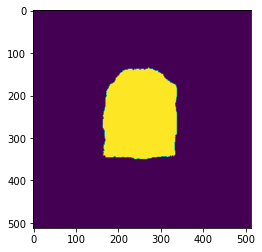

In [25]:
plt.imshow(out1.cpu().detach().numpy())
plt.imsave('test1.jpg',out1.cpu().detach().numpy())

In [34]:
plt.imsave('test.jpg',out.cpu().detach().numpy().stype(np.uint16))

AttributeError: 'numpy.ndarray' object has no attribute 'stype'

In [12]:
model.load_state_dict(torch.load('D:/pytorch/carvana-image-masking-challenge/model.tar'))

<All keys matched successfully>

In [26]:
file = glob.glob('D:/pytorch/carvana-image-masking-challenge/train/*.jpg')
final_mean_r = []
final_mean_g = []
final_mean_b = []

final_std_r = []
final_std_g = []
final_std_b = []

for i in file:
    im = cv2.imread(i)
    #im = np.resize(im,(512,512,3))
    im_r = np.reshape(im[:,:,0],-1)
    im_g = np.reshape(im[:,:,1],-1)
    im_b = np.reshape(im[:,:,2],-1)
    
    mean_r = np.mean(im_r)
    mean_g = np.mean(im_g)
    mean_b = np.mean(im_b)
    final_mean_r.append(mean_r)
    final_mean_g.append(mean_g)
    final_mean_b.append(mean_b)
    
    std_r = np.std(im_r)
    std_g = np.std(im_g)
    std_b = np.std(im_b)
    final_std_r.append(std_r)
    final_std_g.append(std_g)
    final_std_b.append(std_b)
    print(len(final_mean_r))
final_mean_r = np.sum(final_mean_r)/len(file)
final_mean_g = np.sum(final_mean_g)/len(file)
final_mean_b = np.sum(final_mean_b)/len(file)
final_std_r = np.sum(final_std_r)/len(file)
final_std_g = np.sum(final_std_g)/len(file)
final_std_b = np.sum(final_std_b)/len(file)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000


In [27]:
print(final_mean_r,final_mean_g,final_mean_b)

175.4601107175443 177.5292627792215 179.6935779875277


In [28]:
print(final_std_r,final_std_g,final_std_b)

59.428060387895556 59.87252463975005 58.69741147983017


In [31]:
file = glob.glob('D:/pytorch/carvana-image-masking-challenge/train_masks/*.gif')
final_mean = []
final_std = []

for i in file:
    im =imageio.mimread(i)
    im = np.array(im)
    im = im.squeeze(0)
    #im = np.resize(im,(512,512))
    im_gr = np.reshape(im[:,:],-1)

    
    mean = np.mean(im_gr)
    final_mean.append(mean)
    
    std = np.std(im_gr)
    final_std.append(std)
    print(len(final_mean))
    
final_mean = np.sum(final_mean)/len(file)
final_std = np.sum(final_std)/len(file)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000


In [32]:
final_mean

53.77615384168894

In [33]:
final_std

102.83887487006633

In [30]:
file = glob.glob('D:/pytorch/carvana-image-masking-challenge/train_masks/*.gif')
x=imageio.mimread(file[1] )
x = np.array(x)
x = x.squeeze(0)
x = np.resize(x,(512,512))
print(np.max(x))
x = np.reshape(x[:,:],-1)
